In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, invgamma, gamma
from scipy.linalg import sqrtm
from scipy.optimize import minimize
import pandas as pd
from tqdm import tqdm

# Корзина опционов

Пример (Krekel, 2004). В рамках модели Блэка-Шоулза вычислите цены опциона колл на корзину с четырьмя акциями, для которых $T = 5~лет$, безрисковая ставка $r = 0$, корреляция $\rho_{ij} = 0,5$, $\forall i \neq j$, $K = 100$, $F^T_i = 100$, $σ_i = 40\%$ и $w_i = 0,25, i, j = 1, 2, 3, 4$.

Используйте аппроксимацию различными методами
* метод условного математического ожидания (Beisser),
* аппроксимация геометрическим средним (Gentel),
* метод моментов (Levy),
* **метод Джу через разложения в ряд Тейлора** (Ju),
* аппроксимация через обратное геометрическое распределение (MP-RG),
* **метод моментов высших порядков** (MP-4M)

и
сравните полученные аппроксимации с методом Монте-Карло.

In [ ]:
T = 5
r = 0
K = 100
N = 4

rho0 = 0.5
rho  = np.ones((N,N)) * rho0 + np.diag(np.ones(N)) * (1 - rho0)
S0   = 100
S    = np.ones(N) * S0
F    = np.ones(N) * S0 * np.exp(r * T)
w    = np.ones(N) / N
q   = np.zeros(N)
sigma = np.ones(N) * 0.4

In [ ]:
rho

array([[1. , 0.5, 0.5, 0.5],
       [0.5, 1. , 0.5, 0.5],
       [0.5, 0.5, 1. , 0.5],
       [0.5, 0.5, 0.5, 1. ]])

## Аппроксимация геометрическим средним (Gentel)

In [ ]:
# аппроксимация корзины опционов геометрическим средним
def geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  a = w * F / np.sum(w * F)

  m_tilde = np.log(np.sum(w * F)) - 0.5 * np.sum(a * sigma ** 2 * T)
  v_tilde = np.sqrt((a * sigma).T @ rho @ (a * sigma) * T)

  K_star =  K - np.sum(w * F) + np.exp(m_tilde + 0.5 * v_tilde ** 2)

  d1 = (m_tilde - np.log(K_star) + v_tilde ** 2) / v_tilde
  d2 = d1 - v_tilde

  basket_call = np.exp(-r * T) * (np.exp(m_tilde + 0.5 * v_tilde ** 2) * norm.cdf(d1) - K_star * norm.cdf(d2))

  return basket_call

In [ ]:
geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)

23.783632811454414

## Метод условного математического ожидания (Beisser)

In [ ]:
def get_z_star(x, S, K, r, q, sigma, T, w, rho):
    res = 0
    a = S * w * sigma
    sqrt_T = np.sqrt(T)
    sigmaz = np.sqrt(a.T @ rho @ a)
    for i in range(0, len(w)):
        m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
        exp_S_Z = S[i] * np.exp(sigma[i] * m * x - 1/2 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
        res += w[i] * exp_S_Z
    return (res - K)**2

def Beisser_approximation_basket_call(S, K, T, w, r, q, sigma):
  basket_call = 0
  a = S * w * sigma
  sigmaz = np.sqrt(a.T @ rho @ a)
  sqrt_T = np.sqrt(T)

  z_star = minimize(get_z_star, 0, args=(S, K, r, q, sigma, T, w, rho)).x[0]
  for i in range(0, len(w)):
    m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
    sigma_star = sigma[i] * m * sigmaz / np.sqrt(T)
    K_star = S[i] * np.exp(sigma[i] * m * z_star - 1/2 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
    S_star = S[i] * np.exp((r - q[i] - 1/2 * sigma_star**2) * T + sigma_star * np.sqrt(T) / sigmaz * z_star)
    d1 = (np.log(S[i] / K_star) + (r - q[i] + 1/2 * sigma_star**2) * T) / (sigma_star * np.sqrt(T))
    d2 = d1 - sigma_star * np.sqrt(T)
    basket_call += w[i] * (np.exp(-q[i] * T) * S[i] * norm.cdf(d1) - np.exp(-r * T) * K_star * norm.cdf(d2))
    return basket_call

In [ ]:
Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)

27.632639023017184

## Задача

### Метод Джу через разложения в ряд Тейлора (Ju)

Статья [(Ju, 2002)](https://drive.google.com/file/d/1JJuZhRiCUGf6euyfju1Dn5aRP46-3iry/view?usp=drive_link)

In [ ]:
def ju_taylor_approximation_call(S, K, T, sigma, w, rho):
# ваш код
    return basket_call
# ответ 28.01

## Метод моментов (Log-normal moment matching, Levy’s matching)

In [ ]:
def Levy_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  M = np.dot(w, F)
  V2 = 0
  for i in range(0, len(w)):
    for j in range(0, len(w)):
      V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
  m = 2 * np.log(M) - 1/2 * np.log(V2)
  v = np.sqrt(np.log(V2) - 2 * np.log(M))
  d1 = (m - np.log(K) + v**2) / v
  d2 = d1 - v
  basket_call = np.exp(-r * T) * (M * norm.cdf(d1) - K * norm.cdf(d2))
  return basket_call

In [ ]:
Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)

28.051966214249894

## Аппроксимация через обратное геометрическое распределение (MP-RG)

In [ ]:
def Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  M = np.dot(w, F)
  V2 = 0
  for i in range(0, len(w)):
    for j in range(0, len(w)):
      V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
  alpha = (2 * V2  - M**2) / (V2 - M**2)
  beta = (V2 - M**2) / (V2 * M)
  g1 = gamma.cdf(1/K, a = alpha - 1, scale = beta)
  g2 = gamma.cdf(1/K, a = alpha, scale = beta)
  basket_call = np.exp(-r * T) * (M * g1 - K * g2)
  return basket_call

In [ ]:
Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)

24.495775089623557

## Задача

### Метод моментов высоких порядков (MP-4M)

Статья [(Posner and Milevsky, 1998)](https://https://drive.google.com/file/d/16f5dRiA_HD9jhm-esUT_6gGoArk9Nc2u/view?usp=drive_link)

In [ ]:
def Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma):
# ваш код
  return basket_call
# ответ = 27.98

## Метод Монте-Карло

In [ ]:
def MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc):
  n = len(w)
  COV = sigma.T * rho * sigma
  W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
  B_T = np.zeros(N_mc)
  S0 = 100
  for k in range(0, n):
      B_T += S[k] * np.exp((r - q[k] - sigma[k]**2 / 2) * T + W[:,k]) * w[k]
  basket_call = np.mean(np.maximum(B_T - K, 0)) * np.exp(-r * T)
  return basket_call

In [ ]:
N_mc = int(10**6)
MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)

28.123961692225844

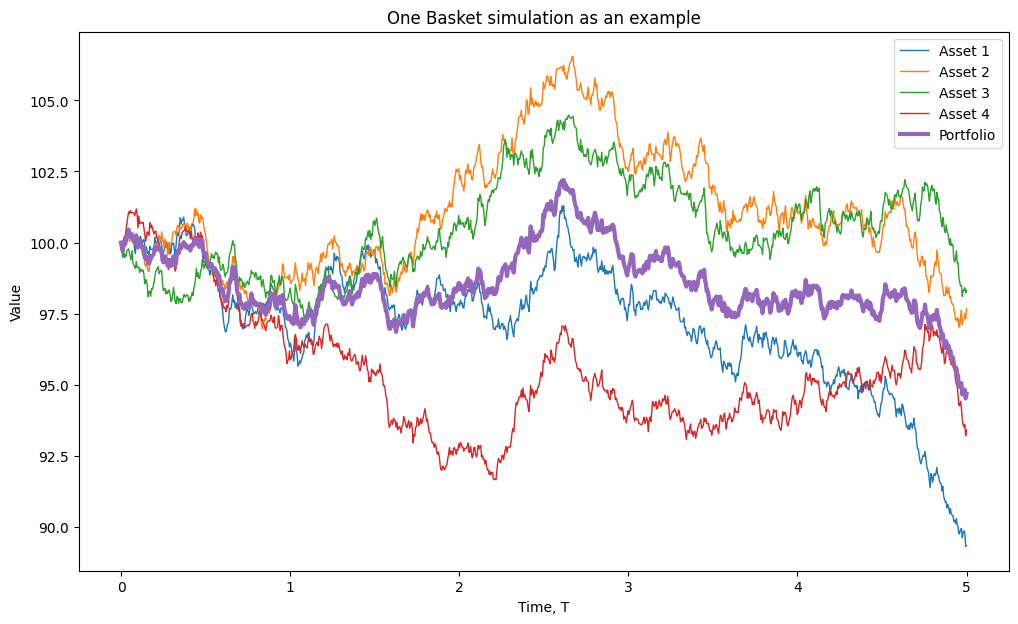

In [ ]:
# Пример одной симуляции методом Монте-Карло для равновесной корзины опционов

n_steps = 1000
dt = T / (n_steps - 1)
S_t = np.zeros((n_steps, 4))
S_t[0] = F
COV = sigma.T * rho * sigma
for i in range(n_steps - 1):
    dW = np.random.multivariate_normal(np.zeros(4), COV) * dt
    dS = r * S_t[i] * dt + S_t[i] * dW
    S_t[i + 1] = S_t[i] + dS

plt.figure(figsize=(12, 7))
t_grid = np.linspace(0, T, n_steps)
plt.plot(t_grid, S_t, lw=1, label = [f'Asset {i + 1}' for i in range(N)])
plt.plot(t_grid, S_t @ w, lw=3,  label='Portfolio')
plt.xlabel('Time, T')
plt.ylabel('Value')
plt.title('One Basket simulation as an example')
plt.legend()
plt.show()

In [ ]:
# МС оценка для кол и пут опционов
n_steps = 5000

dt = T / (n_steps - 1)
COV = sigma.T * rho * sigma

S = np.zeros((n_sims, 4))
S[...] = F

for i in tqdm(range(n_steps - 1)):
    dW = np.random.multivariate_normal(np.zeros(4), COV, size=N_sims) * np.sqrt(dt)
    dS = r * S * dt + S * dW
    S += dS

portfolio_values = S @ w

call_price_mc = np.maximum(portfolio_values - K, 0).mean()
put_price_mc = np.maximum(K - portfolio_values, 0).mean()

print('Call price by Monte-Carlo:', call_price_mc)
print('Put price by Monte-Carlo:', put_price_mc)

100%|██████████| 4999/4999 [00:11<00:00, 433.33it/s]

Call price by Monte-Carlo: 28.15747350535152
Put price by Monte-Carlo: 27.80143782145992


Пример. Для метода Монте-Карло реализуйте функцию для вычисления стандартного отклонения
$
StdDev = \sqrt{\frac{1}{n}\sum_{i=1}^n(Price - MC\,Price)^2}
$
и постройте доверительный интервал для оценки.

In [ ]:
def MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc):
  n = len(w)
  COV = sigma.T * rho * sigma
  W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
  B_T = np.zeros(N_mc)
  S0 = 100
  for k in range(0, n):
      B_T += S[k] * np.exp((r - q[k] - sigma[k]**2 / 2) * T + W[:,k]) * w[k]
  payoff = np.maximum(B_T - K, 0)
  mean = np.mean(payoff) * np.exp(-r * T)
  std = np.std(payoff) * np.exp(-r * T)
  return call_price_mc, std

def CI_MC(price, price_std, N_mc):
    lo = price - norm.ppf(0.975)*price_std / np.sqrt(N_mc)    # lower bound of confidence interval for the price
    hi = price + norm.ppf(0.975)*price_std / np.sqrt(N_mc)    # upper bound of confidence interval for the price
    print(f"mean call basket price = {price}, ci: {lo} < price < {hi} with 95% prob")

In [ ]:
MC_call, MC_std = MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc)
CI_MC(MC_call, MC_std, N_mc)

mean call basket price = 28.15747350535152, ci: 28.02651207401376 < price < 28.288434936689278 with 95% prob


### Задача

In [ ]:
# Постройте гистограммы распределения МС оценок для опионов кол и пут,
# на графики нанесите границы доверительного интервала, среднее значение (вертикальные линии),
# выдвините гипотезу о законе распределения оценок и проверьте ее статистически.

# ваш код

## Исследование влияния параметров модели на оценку стоимости корзины опцинов

Пример.
Проведите исследование влияния параметров (варьировать один параметр, остальные -- зафиксировать) для различных методов аппроксимации и постройте графики, на которых отобразите зависимость для следующих значений параметров:  

* цена страйк $K=\{50, 60, \ldots, 150\}$,
* форвардная цена $F^T=\{50, 60, \ldots, 150\}$,
* корреляция  $\rho=\{0.1, 0.2, \ldots, 0.9, 0.95\}$,
* волатильность $\sigma=\{0.1, 0.2, \ldots, 0.9, 1.0\}$,
* веса $w_1 = \{0.5, 0.2, 0.2, 0.1\}$, $w_2 = \{0.7, 0.1, 0.1, 0.1\}$,
* безрисковая ставка $r=\{0.01, 0.02, 0.05, 0.1\}$.


### Задача.

In [ ]:
# На графики добавить кривые, полученные для методов Ju и MP-4M,
# предложите свою визуализацию для корзин с разными весами активов
# ваш код допишите в ячейке ниже

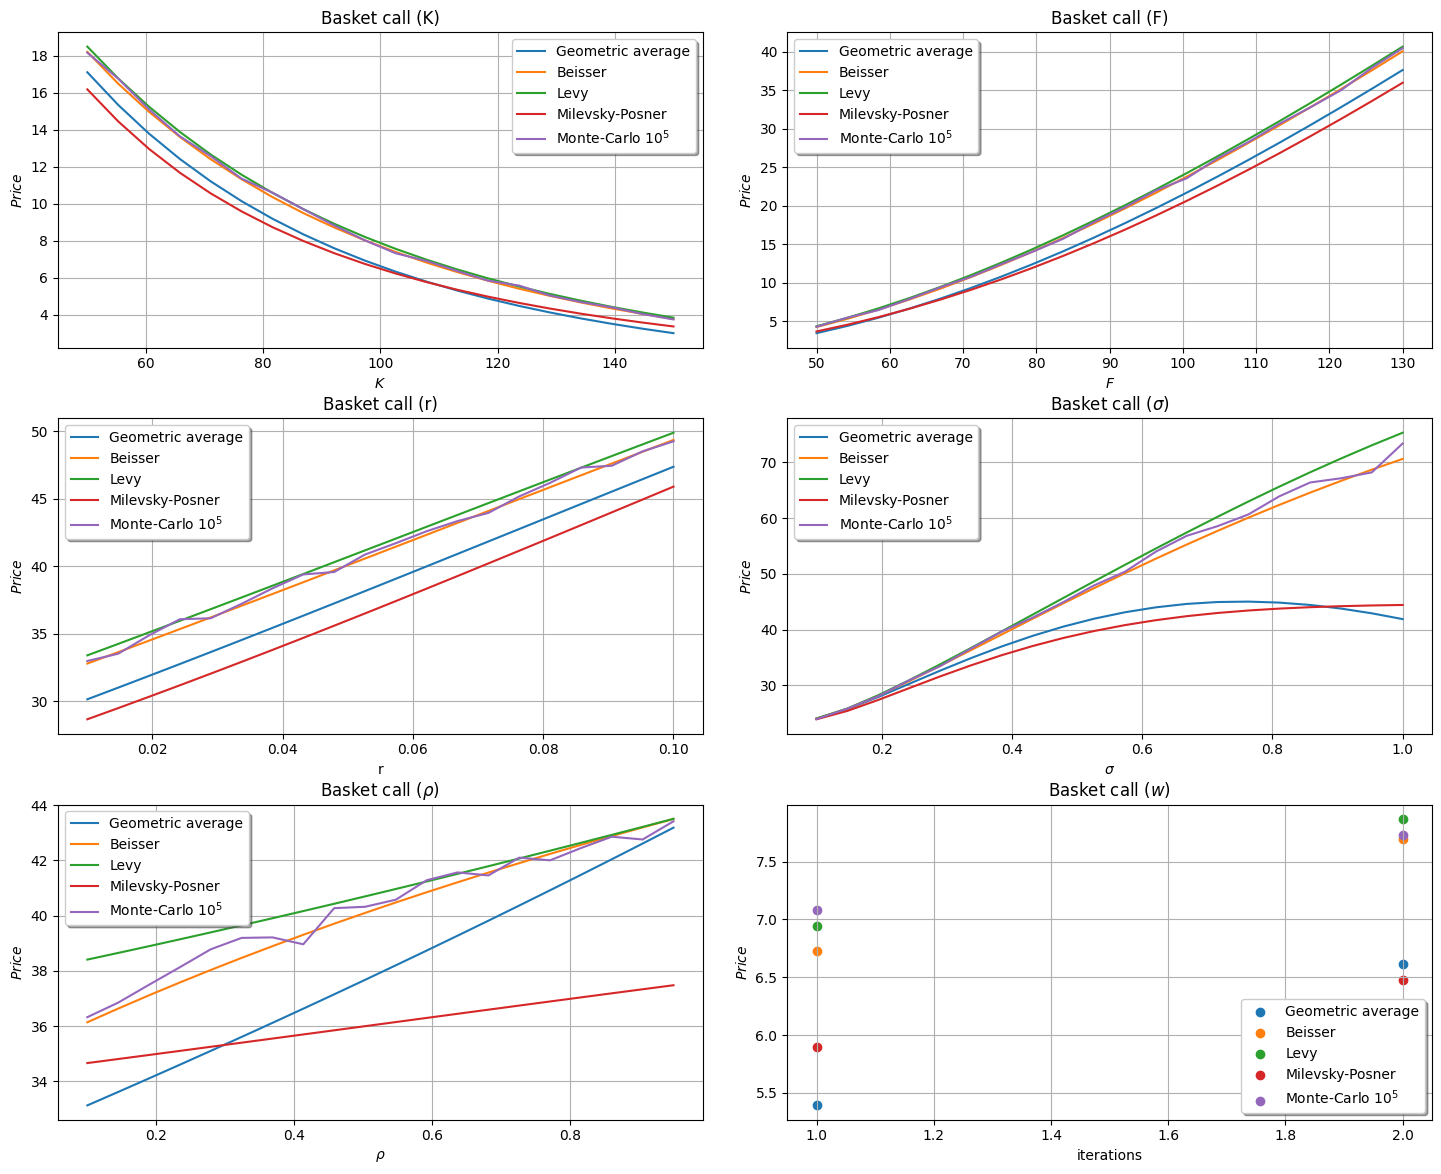

In [ ]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 12))
fig.tight_layout(pad=3.0)


'''K research'''
iters = 20
K_data = np.linspace(50, 150, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)

for i in range(0, iters):
    geom_avg[i] = geometric_average_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K_data[i], T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K_data[i], T, w, r, q, rho, sigma, N_mc)


axs[0][0].plot(K_data, geom_avg, label = 'Geometric average')
axs[0][0].plot(K_data, Beisser, label = 'Beisser')
axs[0][0].plot(K_data, Levy, label = 'Levy')
axs[0][0].plot(K_data, MP, label = 'Milevsky-Posner')
axs[0][0].plot(K_data, MC, label = r'Monte-Carlo')
axs[0][0].set_title('Basket call (K)')
axs[0][0].set_xlabel(r'$K$')
axs[0][0].set_ylabel(r'$Price$')
axs[0][0].legend(loc = 'best', fancybox = True, shadow = True)
axs[0][0].grid(True)

'''F research'''
iters = 20
F_data = np.linspace(50, 130, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)

for i in range(0, iters):
    S0 = F_data[i] * np.exp(-r * T)
    S = S0 * np.ones(N)
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)


axs[0][1].plot(F_data, geom_avg, label = 'Geometric average')
axs[0][1].plot(F_data, Beisser, label = 'Beisser')
axs[0][1].plot(F_data, Levy, label = 'Levy')
axs[0][1].plot(F_data, MP, label = 'Milevsky-Posner')
axs[0][1].plot(F_data, MC, label = r'Monte-Carlo')
axs[0][1].set_title('Basket call (F)')
axs[0][1].set_xlabel(r'$F$')
axs[0][1].set_ylabel(r'$Price$')
axs[0][1].legend(loc = 'best', fancybox = True, shadow = True)
axs[0][1].grid(True)


'''sigma research'''
iters = 20
S = S0 * np.ones(N)
sigma_data = np.linspace(0.1, 1.0, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)

for i in range(0, iters):
    sigma = np.ones(N) * sigma_data[i]
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)

axs[1][1].plot(sigma_data, geom_avg, label = 'Geometric average')
axs[1][1].plot(sigma_data, Beisser, label = 'Beisser')
axs[1][1].plot(sigma_data, Levy, label = 'Levy')
axs[1][1].plot(sigma_data, MP, label = 'Milevsky-Posner')
axs[1][1].plot(sigma_data, MC, label = r'Monte-Carlo')
axs[1][1].set_title(r'Basket call ($\sigma$)')
axs[1][1].set_xlabel(r'$\sigma$')
axs[1][1].set_ylabel(r'$Price$')
axs[1][1].legend(loc = 'best', fancybox = True, shadow = True)
axs[1][1].grid(True)


'''r research'''
iters = 20
S = S0 * np.ones(N)
sigma = np.ones(N) * 0.4
r_data = np.linspace(0.01, 0.1, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)

for i in range(0, iters):
    r = r_data[i]
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)

axs[1][0].plot(r_data, geom_avg, label = 'Geometric average')
axs[1][0].plot(r_data, Beisser, label = 'Beisser')
axs[1][0].plot(r_data, Levy, label = 'Levy')
axs[1][0].plot(r_data, MP, label = 'Milevsky-Posner')
axs[1][0].plot(r_data, MC, label = r'Monte-Carlo')
axs[1][0].set_title(r'Basket call (r)')
axs[1][0].set_xlabel(r'r')
axs[1][0].set_ylabel(r'$Price$')
axs[1][0].legend(loc = 'best', fancybox = True, shadow = True)
axs[1][0].grid(True)


'''rho research'''
iters = 20
r = 0.05
S = S0 * np.ones(N)
sigma = np.ones(N) * 0.4
rho_data = np.linspace(0.1, 0.95, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)

for i in range(0, iters):
    rho = np.ones((N,N)) * rho_data[i] + np.diag(np.ones(N)) * (1 - rho_data[i])
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)

axs[2][0].plot(rho_data, geom_avg, label = 'Geometric average')
axs[2][0].plot(rho_data, Beisser, label = 'Beisser')
axs[2][0].plot(rho_data, Levy, label = 'Levy')
axs[2][0].plot(rho_data, MP, label = 'Milevsky-Posner')
axs[2][0].plot(rho_data, MC, label = r'Monte-Carlo')
axs[2][0].set_title(r'Basket call ($\rho$)')
axs[2][0].set_xlabel(r'$\rho$')
axs[2][0].set_ylabel(r'$Price$')
axs[2][0].legend(loc = 'best', fancybox = True, shadow = True)
axs[2][0].grid(True)


'''w research'''
iters = 2
r = 0.05
S = S0 * np.ones(N)
sigma = np.ones(N) * 0.4
rho = np.ones((N,N)) * 0.5 + np.diag(np.ones(N)) * (1 - 0.5)
w_data = np.array([[0.5, 0.2, 0.2, 0.1],[0.7, 0.1, 0.1, 0.1]])
S_data = np.array([[50, 40, 60, 30],[50, 40, 60, 30]])
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
iterations = [1, 2]
for i in range(0, iters):
    S = S_data[i]
    w = w_data[i]
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)

axs[2][1].scatter(iterations, geom_avg, label = 'Geometric average')
axs[2][1].scatter(iterations, Beisser, label = 'Beisser')
axs[2][1].scatter(iterations, Levy, label = 'Levy')
axs[2][1].scatter(iterations, MP, label = 'Milevsky-Posner')
axs[2][1].scatter(iterations, MC, label = r'Monte-Carlo')
axs[2][1].set_title(r'Basket call ($w$)')
axs[2][1].set_xlabel(r'iterations')
axs[2][1].set_ylabel(r'$Price$')
axs[2][1].legend(loc = 'best', fancybox = True, shadow = True)
axs[2][1].grid(True)

In [ ]:
def pdfs_comparison():
  iters = 100
  S_data = np.linspace(50, 150, iters)
  geom_avg = np.zeros(iters)
  Beisser = np.zeros(iters)
  Levy = np.zeros(iters)
  MP = np.zeros(iters)
  MC = np.zeros(iters)

  for i in range(0, iters):
    S0 = S_data[i]
    S = S0 * np.ones(N)
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, int(10**5))

  plt.plot(S_data, geom_avg, label = 'Gentel')
  plt.plot(S_data, Beisser, label = 'Beisser')
  plt.plot(S_data, Levy, label = 'Levy')
  plt.plot(S_data, MP, label = 'MP-RG')
  plt.plot(S_data, MC, label = r'MC, $N=10^5$')
  plt.title('Basket call')
  plt.xlabel(r'$S_0$')
  plt.legend(loc = 'best', fancybox = True, shadow = True)
  plt.grid(True)

  pdfs_comparison()

# Мини-проект (оценка корзины нейронной сетью)

Оцените корзину европейских опционов с помощью полносвязанной модели нейронной сети.

*  Сгенерируйте цены для $10 000$ опционных корзин, используя одну из аналитических аппроксимаций.
*  Обучите полностью связанную искусственную нейронную сеть для оценки стоиомости опционов.
*  Сравните полученные оценки с Монте-Карло оценками.
Приведите иллюстративные графики.


1. Корзина европейских опционов колл + Gentel
1. Корзина европейских опционов колл + Beisser
1. Корзина европейских опционов колл + Ju
1. Корзина европейских опционов колл + Levy
1. Корзина европейских опционов колл + MP-RG
1. Корзина европейских опционов колл + MP-4M
1. Корзина европейских опционов пут + Gentel
1. Корзина европейских опционов колл + Beisser
1. Корзина европейских опционов колл + Ju
1. Корзина европейских опционов колл + Levy
1. Корзина европейских опционов колл + MP-RG
1. Корзина европейских опционов колл + MP-4M

Option Pricing with Deep Learning

[Отчет](https://cs230.stanford.edu/projects_fall_2019/reports/26260984.pdf) [Постер](https://cs230.stanford.edu/projects_fall_2019/posters/26260929.pdf)
[Пример.](https://github.com/nluciw/pricing_basket_options/blob/main/main_analysis.ipynb)

In [ ]:
# ваш код